# LangChain (Legacy)

## Stat Agent

In [30]:
# SubAgents

from langchain.tools import tool
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import f
import pandas as pd
import numpy as np
from scipy.linalg import eigh

def calculate_PC(data):
    '''
    Calculate the principal components of the input data
    '''
    mu = data.to_numpy().mean(axis=0)
    std = data.to_numpy().std(axis=0)

    standardized_data = (data.to_numpy()-mu)/std
    cov_matrix = np.cov(standardized_data, rowvar=False)

    eigenvalue,eigenvector = eigh(cov_matrix)
    eigenvalue = eigenvalue[::-1]
    eigenvector = eigenvector[:,::-1]

    # Apply 1st 2 principal components to the dataset
    transformed_data = standardized_data @ np.vstack((eigenvector[:,0], eigenvector[:,1])).T
    
    pc1 = transformed_data[:,0].tolist()
    pc2 = transformed_data[:,1].tolist()

    return [pc1,pc2] 


def levene_test(data):
    ''' 
    Calculate the equality of variances for 2 or more groups | F(1-aplha, N-k)
    
    Args:
    data (pd.dataframe): dataframe of groups
    k (int): numner of different groups to which the sampled case belong
    N (int): total number of cases in all groups
    Ni (int): number of cases in the ith group
    Yij (array): the value of the measured variable for the jth case from the ith group
    Zij (float): the mean or median of the ith group
    Zi (float): is the mean of the Zij for group i
    Z (float): is the mean of all Zij

    Return:
    W (float): F statistic 0.05
    pval (float): p value
    '''
    data = np.array(data).T

    N = data.shape[0]*data.shape[1]
    k = data.shape[1]
    Ni = data.shape[0]

    Zij = [np.abs(data.T[i]-data.T[i].mean()) for i in range(k)]

    Zi = [np.divide(1,Ni)*np.sum(Zij[i]) for i in range(k)]

    Z = np.divide(1,N)*np.sum([np.sum(Zij[i]) for i in range(k)])

    W = np.divide((N-k),(k-1))*np.divide(np.sum(Ni*(Zi-Z)**2),np.sum([np.sum((Zij[i]-Zi[i])**2) for i in range(k)]))
    
    pval = 1-f.cdf(W,k-1,N-k)

    return W, pval

def anova_one_way(dd):
    '''     
    Args:
    X (float): overall mean
    Xj (float): mean of group j
    n (int): sample size of group j
    Xij = the ith observation in group j

    '''

    k = dd.shape[1]
    n = dd.shape[0]
    N = k*n

    X = np.array([dd[col].mean() for col in dd.columns]).mean()
    Xj = np.array([dd[col].mean() for col in dd.columns])
    Xij = np.array([dd[col]for col in dd.columns])

    SSR = n*np.sum((Xj-X)**2) # Regression sum of squares
    SSE = np.sum([np.sum((Xij[i]-Xj[i])**2) for i in range(len(Xj))]) # Error sum of squares
    SST = SSR+SSE # Total sum of squares

    df1 = k-1
    df2 = N-k

    MS = SSR/df1 # Mean squares
    MSE = SSE/df2 # Mean square error
    F = MS/MSE # F-statistic
    pval = 1-f.cdf(F,k-1,N-k)
    return F, pval

@tool
def get_columns(col_input) -> list:
    '''
    Pull columns to perform statistics on
    '''
    if col_input == "all" or "*":
       
        columns = df.columns.to_list()
        return columns

@tool
def covariance_tool(columns: str):
    '''
    Calculate the covariance of the columns of data 

    Args:
    columns (str): list of columns to perform covariance calculation

    Return:
    Response with the calculated covariance matrix
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    
    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    cov_matrix = df[columns].cov()
    return f' Covariance Matrix: \n{cov_matrix.to_string()}'

@tool
def correlation_tool(columns: str):
    '''
    Calculate the correlation of the columns of data

    Args:
    columns (str): list of columns to perform correlation calculation on

    Return:
    Response with the calculated correlation matrix
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    corr_matrix = df[columns].corr()
    return f'Correlation Matrix: {corr_matrix.to_string()}'

@tool
def normality_tool(columns: str):
    '''
    Calculate if the input data is normal

    Args:
    df (pd.dataframe): dataframe containig raw data

    Return:
    Response on whether data is normal or not, explicitly stating which columns are not
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'

    not_normal = []

    for col in columns:
        tstat, pval = shapiro(df[col])
        if pval < 0.05: # reject H0
            not_normal.append(col)
            return f'Column {col} is not normally distributed, and not recommended to include in ANOVA analysis'
    return f'Data is normal'

@tool
def levene_test_tool(columns: str):
    ''' 
    Calculate the equality of variances for 2 or more groups | F(1-aplha, N-k)
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    

    data = df[columns]
    

    return levene_test(data)

@tool    
def calculate_ANOVA_tool(columns: str):
    '''
    Compare the means of 3 or more independant groups to determine statistical difference between popuplaiton means.
    H0: The mean of the independent groups are all the same, there is no statistical difference. difference is due to random sampling from same population
    Test for normality within ea group with shapiro-wilks test (H0: data was drawn from a normal distribution) pval < 0.05 reject H0
    Test for homegenity of variance with levene test (H0: data has equal variance) p_val < 0.05 reject H0 at lease 1 of the groups is not heteroskedastic Anova can be used
    H0: two or more groups have the same population mean
    Calculate the amount of variance between groups means to the amount of variation within each group  group variation > within group variation => difference in mean not random
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    missing = [col for col in columns if col not in df.columns]
    if missing:
        return f'Columns not found: {','.join(missing)}'
    

    data = df[columns]
    

    return anova_one_way(data)

@tool
def PCA_tool(columns: str) ->list:
    '''
    Calculates the 1st two principal components of a dataset
    '''

    columns = [col.strip().strip('"').strip("'") for col in columns.split(',')]

    
    return calculate_PC(df[columns])

@tool
def plot_data(mylist: str):
    '''
    Create a scatter plot 
    '''
    import matplotlib.pyplot as plt 
    import ast
    
    mylist = mylist.strip('" "')
    mylist = ast.literal_eval(mylist)
    pc1 = np.array(mylist[0])
    pc2 = np.array(mylist[1])



    plt.scatter(pc1,pc2)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    # plt.savefig("pca_result.png")
    plt.show()
    return "PCA plot saved to pca_result.png"




In [31]:
from langchain.agents import initialize_agent, AgentType
from langchain_community.chat_models import BedrockChat
from langchain.memory import ConversationBufferMemory

def stat_agent():
    ''' 
    One-shot Stat Agent
    '''
    memory = ConversationBufferMemory(memory_key='chat_history', return_message=True)
    llm = BedrockChat(model_id='anthropic.claude-3-5-sonnet-20240620-v1:0', region_name='us-east-1', model_kwargs={'max_tokens': 3000, 'temperature': 0})

    sub_agent = [covariance_tool, correlation_tool, normality_tool, levene_test_tool, get_columns, calculate_ANOVA_tool, PCA_tool, plot_data]

    agent = initialize_agent(
        tools=sub_agent,
        llm=llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True,
        memory=memory,
        agent_kwargs={'system_message': 'You are a Statistics agent '}
    )
    return agent





/tmp/ipykernel_4651/2534861037.py:9: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key='chat_history', return_message=True)
/tmp/ipykernel_4651/2534861037.py:10: LangChainDeprecationWarning: The class `BedrockChat` was deprecated in LangChain 0.0.34 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-aws package and should be used instead. To use it run `pip install -U :class:`~langchain-aws` and import as `from :class:`~langchain_aws import ChatBedrock``.
  llm = BedrockChat(model_id='anthropic.claude-3-5-sonnet-20240620-v1:0', region_name='us-east-1', model_kwargs={'max_tokens': 3000, 'temperature': 0})
/tmp/ipykernel_4651/2534861037.py:14: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full



> Entering new AgentExecutor chain...
To answer this question, we need to follow these steps:
1. Get all the columns from the dataframe
2. Calculate the principal components using those columns
3. Create a scatter plot of the first two principal components

Let's start with getting all the columns.

Action: get_columns
Action Input: all

Observation: ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12']
Thought:Great, we now have all the columns from the dataframe. Let's proceed with calculating the principal components using these columns.

Action: PCA_tool
Action Input: A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12

Observation: [[-0.8279801125859164, -1.8748439208408956, -0.9639972848511245, 1.7064715093789358, -3.674450747526948, 1.5901198630406577, -0.9601324619449182, -2.3963045488865466, 0.6049511023882346, 0.20410869888476968, 0.9799686007125502, -0.9871319474789318, -0.2531322066426445, 2.9761087256826713, 3.496544317832839, -0.04073974852588082, -0.1

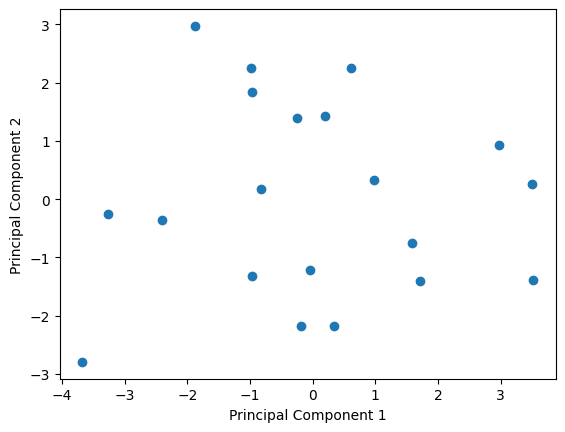


Observation: PCA plot saved to pca_result.png
Thought:Thought: I now know the final answer. We have successfully completed all the required steps to answer the question.

Final Answer: We have obtained all the columns from the dataframe, calculated the principal components using those columns, and created a scatter plot of the first two principal components. The process involved the following steps:

1. We retrieved all the columns from the dataframe using the get_columns tool, which returned 13 columns (A0 to A12).

2. We then used the PCA_tool to calculate the principal components using all these columns. This tool returned the first two principal components.

3. Finally, we used the plot_data tool to create a scatter plot of these two principal components. The scatter plot has been saved as 'pca_result.png'.

This scatter plot visualizes the data points in the space of the first two principal components, which represent the directions of maximum variance in the dataset. This can he

{'input': 'Get all the columns from df and calculate the principal components then create a scatter plot of the 2 different principal components',
 'chat_history': '',
 'output': "We have obtained all the columns from the dataframe, calculated the principal components using those columns, and created a scatter plot of the first two principal components. The process involved the following steps:\n\n1. We retrieved all the columns from the dataframe using the get_columns tool, which returned 13 columns (A0 to A12).\n\n2. We then used the PCA_tool to calculate the principal components using all these columns. This tool returned the first two principal components.\n\n3. Finally, we used the plot_data tool to create a scatter plot of these two principal components. The scatter plot has been saved as 'pca_result.png'.\n\nThis scatter plot visualizes the data points in the space of the first two principal components, which represent the directions of maximum variance in the dataset. This can 

In [32]:
from sklearn.datasets import load_wine

stat_agent = stat_agent()
# df = pd.read_csv('sample_df.csv')
data = load_wine()
lbl = data['target_names']
header = [a+str(n) for n,a in enumerate(np.repeat('A',data['data'].shape[1]))]
df = pd.DataFrame(data['data'], columns=header)
df = df.iloc[:20,:]

stat_agent.invoke('Get all the columns from df and calculate the principal components then create a scatter plot of the 2 different principal components')



# function dev

In [33]:
!pwd

/mnt/custom-file-systems/efs/fs-0252e317d4af1dc34_fsap-0a708b50be80889d5/CLONED_REPOS/LLM-World/Notebooks


In [51]:
import sys
sys.path.append("/mnt/custom-file-systems/efs/fs-0252e317d4af1dc34_fsap-0a708b50be80889d5/CLONED_REPOS/LLM-World/")
sys.path.append('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/src/')
import requests
import os
import boto3
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
load_dotenv("/mnt/custom-file-systems/efs/fs-0252e317d4af1dc34_fsap-0a708b50be80889d5/CLONED_REPOS/LLM-World/.env")
from langchain_aws import ChatBedrockConverse 

def get_openai_llms():
    '''get a list of llms available in Azure OpenAI'''
    response = requests.get(os.getenv('AZURE_OPENAI_BASEURL'))
    returned_payload = response.json()

    return [models for models in returned_payload['nonprod'].keys()]


def get_aws_llms():
    '''get a list of llms available in AWS Bedrock'''
    bedrock_client = boto3.client('bedrock', region_name='us-east-1')

    response = bedrock_client.list_foundation_models()

    llm_dict = {}
    for obj in  response['modelSummaries']:
        llm_dict[obj['modelName']] = obj['modelId']

    return llm_dict

def aws_llm(modelid: str):  
    '''Create LangChain Object for AWS Bedrock llm'''     

    return ChatBedrockConverse(model_id=modelid, region_name='us-east-1')

def openai_llm(modle_id: str):
    '''Create LangChain LLM object for Azure OpenAI llm'''
    api_response = requests.get(os.getenv('AZURE_OPENAI_BASEURL'))
    payload = api_response.json()

    gllm = AzureChatOpenAI(
        deployment_name=modle_id,  
        openai_api_version="2024-12-01-preview",
        azure_endpoint=payload['nonprod'][modle_id][0]['endpoint'],
        api_key=os.getenv('AZURE_OPENAI_KEY'),
        temperature=0)
    return gllm

In [57]:
print(get_aws_llms(),'\n')
print(get_openai_llms(), '\n')

{'Pegasus v1.2': 'twelvelabs.pegasus-1-2-v1:0', 'Claude Opus 4.1': 'anthropic.claude-opus-4-1-20250805-v1:0', 'Titan Text Large': 'amazon.titan-tg1-large', 'Titan Image Generator G1': 'amazon.titan-image-generator-v1', 'Titan Image Generator G1 v2': 'amazon.titan-image-generator-v2:0', 'Nova Premier': 'amazon.nova-premier-v1:0', 'Titan Text G1 - Premier': 'amazon.titan-text-premier-v1:0', 'Nova Pro': 'amazon.nova-pro-v1:0', 'Nova Lite': 'amazon.nova-lite-v1:0', 'Nova Canvas': 'amazon.nova-canvas-v1:0', 'Nova Reel': 'amazon.nova-reel-v1:1', 'Nova Micro': 'amazon.nova-micro-v1:0', 'Nova Sonic': 'amazon.nova-sonic-v1:0', 'Titan Text Embeddings v2': 'amazon.titan-embed-g1-text-02', 'Titan Text G1 - Lite': 'amazon.titan-text-lite-v1', 'Titan Text G1 - Express': 'amazon.titan-text-express-v1', 'Titan Embeddings G1 - Text': 'amazon.titan-embed-text-v1', 'Titan Text Embeddings V2': 'amazon.titan-embed-text-v2:0', 'Titan Multimodal Embeddings G1': 'amazon.titan-embed-image-v1', 'SDXL 1.0': 'sta

In [74]:
from langchain.agents import initialize_agent, AgentType
from langchain_community.chat_models import BedrockChat
from langchain.memory import ConversationBufferMemory
from mytools import MyTools

def stat_agent():
    ''' 
    One-shot Stat Agent
    '''
    memory = ConversationBufferMemory(memory_key='chat_history', return_message=True)
    # llm = openai_llm('gpt-4.1')
    llm = aws_llm('us.'+aws_llm(get_aws_llms()['Claude Sonnet 4']).model_id)

    mytools = MyTools()

    # sub_agent = [covariance_tool, correlation_tool, normality_tool, levene_test_tool, get_columns, calculate_ANOVA_tool, PCA_tool, plot_data]
    sub_agent = [mytools.covariance_tool, mytools.correlation_tool, mytools.normality_tool, mytools.levene_test, mytools.anova_one_way, mytools.calculate_PC, mytools.gen_plot]#, mytools.display_base64_image]

    agent = initialize_agent(
        tools=sub_agent,
        llm=llm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True,
        memory=memory,
        agent_kwargs={'system_message': 'You are a Statistics agent'}
    )
    return agent





In [82]:
file_path = '/mnt/custom-file-systems/efs/fs-0252e317d4af1dc34_fsap-0a708b50be80889d5/CLONED_REPOS/LLM-World/Files/wine_data.csv'

In [76]:
from sklearn.datasets import load_wine
import pandas as pd

# df = pd.read_csv('sample_df.csv')
data = load_wine()
lbl = data['target_names']
header = [a+str(n) for n,a in enumerate(np.repeat('A',data['data'].shape[1]))]
df = pd.DataFrame(data['data'], columns=header)
df = df.iloc[:20,:]
df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [92]:
agent = stat_agent()
agent.call({'input': f'Get all the columns from {file_path} and calculate the principal components then create a scatter plot of the 2 different principal components'})
# agent.invoke(f'Get all the columns from {file_path} and calculate the principal components then create a scatter plot of the 2 different principal components')



TypeError: Chain.__call__() missing 1 required positional argument: 'inputs'

# Langgraph One-Shot-Agent

In [17]:
import os
import sys
sys.path.append('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/src')
from mytools import MyTools
from utils import Utils

from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent

from langchain_mcp_adapters.client import MultiServerMCPClient

from dotenv import load_dotenv
load_dotenv('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/.env')

raw_data_path = '/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data_w_target.csv'
# raw_data_path = '/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data.csv'
# annotations_path = '/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data_target.csv'

In [18]:
mcp_client = MultiServerMCPClient(
    {
        "mcp_tools":{
            "url":os.getenv("MCP_URL"),
            "transport":"sse"
        }
    })

system_prompt = ChatPromptTemplate(
    [
        (
            "system", "You are a statistics agent.\n\n"
            "INSTRUCTIONS:\n"
            "- Assist with statistics-related tasks.\n\n"
            "- Call the appropriate tool to complete a task.\n\n"
            '- List you reasoning when completing a task.\n\n'
            "- Respond with the results of your work, explaining the final result in clear detail."
            ),
            (
                "placeholder", "{messages}"
            )
    ]
)

tools = MyTools()
helper = Utils()

mcp_tools = await mcp_client.get_tools()
mcp_tool = None
for obj in mcp_tools:
    if obj.name == "google_search_tool":
        mcp_tool=obj

tools = [tools.correlation_tool, tools.covariance_tool, tools.anova_one_way, tools.levene_test, tools.normality_tool, tools.calculate_PC, tools.gen_plot, tools.display_base64_image,mcp_tool]

In [19]:
one_shot_agent = create_react_agent(
    model = helper.openai_llm("gpt-4.1"),
    tools=tools,
    prompt=system_prompt,
    name="statistics_agent"
    )

In [24]:
import asyncio

# query = 'Using google search provide an explination of What normality is'
# query = f'Could you perform an normality check on {raw_data_path}?'
# query = 'Provide information for gene P53 from the human protein atlas using google'
# query = 'Generate a line plot with the title "Sales Over Time. The x-axis should be [1, 2, 3, 4, 5] representing months, and the y-axis should be [10, 20, 15, 30, 25] representing sales in thousands.'
# query = 'hi'
query = f"calculate the principal components of {raw_data_path} and uset the 'target' column to label the points"


In [25]:
# query = f'Calculate the principal components of all the columns in {raw_data_path} and could you provide a scatter plot of the results using {annotations_path} as labels for the data'

final_response = one_shot_agent.invoke({'messages':[{'role':'user','content': [{'type': 'text', 'text':query}]}]})


In [26]:
final_response

{'messages': [HumanMessage(content=[{'type': 'text', 'text': "calculate the principal components of /home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data_w_target.csv and uset the 'target' column to label the points"}], additional_kwargs={}, response_metadata={}, id='457ca291-a23e-4b81-bfb3-f89a85e3f50e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hWSSdZxqYUN4TNYEz1vGMLTX', 'function': {'arguments': '{"path":"/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/Files/wine_data_w_target.csv"}', 'name': 'calculate_PC'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 627, 'total_tokens': 670, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_c79ab

In [13]:
final_response['messages'][-1].content

'Hello! How can I assist you with statistics today? If you have data to analyze, need help with statistical concepts, or want to run a specific test, just let me know!'

In [27]:
# from langchain_core.messages.ai import AIMessage
from langchain_core.messages import ToolMessage 

image_path = None

for obj in final_response['messages']:
    # print(obj.text)
    if isinstance(obj, ToolMessage):
        # print(obj.content)        
        if obj.name=='gen_plot':
            print(obj.content)
            image_path=obj.content

print(image_path)

generated_plots/plot_20250902_184547_59c25673.png
generated_plots/plot_20250902_184547_59c25673.png


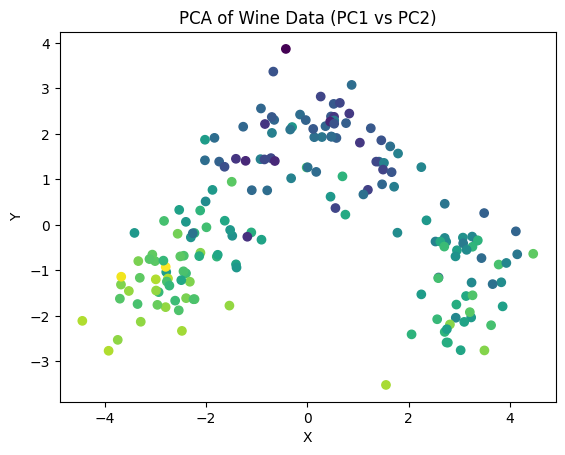

In [28]:
from PIL import Image

Image.open(image_path)